# CLF Prereq

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
pevogam_ucf101_path = kagglehub.dataset_download('pevogam/ucf101')

print('Data source import complete.')


Data source import complete.


In [2]:
!ls /kaggle/input/ucf101/UCF101/UCF-101/

ApplyEyeMakeup	   Drumming	       MilitaryParade	   Shotput
ApplyLipstick	   Fencing	       Mixing		   SkateBoarding
Archery		   FieldHockeyPenalty  MoppingFloor	   Skiing
BabyCrawling	   FloorGymnastics     Nunchucks	   Skijet
BalanceBeam	   FrisbeeCatch        ParallelBars	   SkyDiving
BandMarching	   FrontCrawl	       PizzaTossing	   SoccerJuggling
BaseballPitch	   GolfSwing	       PlayingCello	   SoccerPenalty
Basketball	   Haircut	       PlayingDaf	   StillRings
BasketballDunk	   Hammering	       PlayingDhol	   SumoWrestling
BenchPress	   HammerThrow	       PlayingFlute	   Surfing
Biking		   HandstandPushups    PlayingGuitar	   Swing
Billiards	   HandstandWalking    PlayingPiano	   TableTennisShot
BlowDryHair	   HeadMassage	       PlayingSitar	   TaiChi
BlowingCandles	   HighJump	       PlayingTabla	   TennisSwing
BodyWeightSquats   HorseRace	       PlayingViolin	   ThrowDiscus
Bowling		   HorseRiding	       PoleVault	   TrampolineJumping
BoxingPunchingBag  HulaHoop	       PommelH

In [3]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [4]:
import glob
import pandas as pd
import cv2
import gc
import numpy as np
import random
import imageio
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from urllib.request import urlopen
from tensorflow_docs.vis import embed

In [5]:
class CFG:
    epochs = 20
    batch_size = 32
    classes = [
        "ApplyEyeMakeup", "ApplyLipstick", "Archery", "BabyCrawling", "BalanceBeam",
        "BandMarching", "BaseballPitch", "Basketball", "BasketballDunk", "BenchPress",
        "Biking", "Billiards", "BlowDryHair", "BlowingCandles", "BodyWeightSquats",
        "Bowling", "BoxingPunchingBag", "BoxingSpeedBag", "BreastStroke", "BrushingTeeth",
        "CleanAndJerk", "CliffDiving", "CricketBowling", "CricketShot", "CuttingInKitchen",
        "Diving", "Drumming", "Fencing", "FieldHockeyPenalty", "FloorGymnastics",
        "FrisbeeCatch", "FrontCrawl", "GolfSwing", "Haircut", "HammerThrow",
        "Hammering", "HandstandPushups", "HandstandWalking", "HeadMassage", "HighJump",
        "HorseRace", "HorseRiding", "HulaHoop", "IceDancing", "JavelinThrow",
        "JugglingBalls", "JumpingJack", "JumpRope", "Kayaking", "Knitting",
        "LongJump", "Lunges", "MilitaryParade", "Mixing", "MoppingFloor",
        "Nunchucks", "ParallelBars", "PizzaTossing", "PlayingCello", "PlayingDaf",
        "PlayingDhol", "PlayingFlute", "PlayingGuitar", "PlayingPiano", "PlayingSitar",
        "PlayingTabla", "PlayingViolin", "PoleVault", "PommelHorse", "PullUps",
        "Punch", "PushUps", "Rafting", "RockClimbingIndoor", "RopeClimbing",
        "Rowing", "SalsaSpin", "ShavingBeard", "Shotput", "SkateBoarding",
        "Skiing", "Skijet", "SkyDiving", "SoccerJuggling", "SoccerPenalty",
        "StillRings", "SumoWrestling", "Surfing", "Swing", "TableTennisShot",
        "TaiChi", "TennisSwing", "ThrowDiscus", "TrampolineJumping", "Typing",
        "UnevenBars", "VolleyballSpiking", "WalkingWithDog", "WallPushups", "WritingOnBoard",
        "YoYo"
    ]
    videos_per_class = 10

In [6]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')

In [7]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(class_names), len(class_names)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [8]:
def save_model(model, filepath):
    model.save(filepath)



In [9]:
def classify_video_url(model, video_url, n_frames=10):
    # Download video from URL
    video = urlopen(video_url)
    with open('temp_video.avi', 'wb') as f:
        f.write(video.read())

    # Create frames from the downloaded video
    video_frames = frames_from_video_file('temp_video.avi', n_frames=n_frames)

    # Predict using the model
    predictions = model.predict(np.expand_dims(video_frames, axis=0))

    # Classify the video based on predictions
    predicted_class = np.argmax(predictions)
    predicted_class_name = CFG.classes[predicted_class]

    print(f"Predicted Class: {predicted_class_name}")
    return predicted_class_name

In [10]:
# Load UCF101 dataset
file_paths = []
targets = []
for i, cls in enumerate(CFG.classes):
    sub_file_paths = glob.glob(f"/kaggle/input/ucf101/UCF101/UCF-101/{cls}/**.avi")[:CFG.videos_per_class]
    file_paths += sub_file_paths
    targets += [i] * len(sub_file_paths)

In [35]:
# Create features
features = []
for file_path in tqdm(file_paths):
    features.append(frames_from_video_file(file_path, n_frames=10))
features = np.array(features)

100%|██████████| 1010/1010 [01:46<00:00,  9.48it/s]


In [36]:
# Split dataset
train_features, val_features, train_targets, val_targets = train_test_split(features, targets, test_size=0.2, random_state=42)

In [49]:
#convert video to images

import os
from PIL import Image

val_dir = "/content/val_frames"
os.makedirs(val_dir, exist_ok=True)

for i, video_clip in enumerate(val_features):
    clip_dir = os.path.join(val_dir, f"video_{i:03d}")
    os.makedirs(clip_dir, exist_ok=True)

    for t, frame in enumerate(video_clip):
        img = Image.fromarray((frame * 255).astype('uint8'))  # if frames are normalized
        img.save(os.path.join(clip_dir, f"frame_{t:04d}.jpg"))

In [50]:
# Create TensorFlow datasets (for uncompress)
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_targets)).shuffle(CFG.batch_size * 4).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((val_features, val_targets)).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)

# Compression

In [11]:
!pip install compressai

In [12]:
import os, glob, argparse, math, itertools
import torch, torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from compressai.zoo import bmshj2018_factorized, ssf2020

/usr/local/lib/python3.11/dist-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


In [18]:
# Paths
val_root = "/content/val_frames"
clip_folders = sorted(glob.glob(os.path.join(val_root, "video_*")))
output_root = "/content/compressed_val"

# Setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
quality = 6
PAD_M = 128
to_tensor = transforms.ToTensor()
model = ssf2020(quality=quality, metric='mse', pretrained=True).to(device)
model.eval()

ScaleSpaceFlow(
  (img_encoder): Encoder(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  )
  (img_decoder): Decoder(
    (0): ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  )
  (img_hyperprio

In [19]:

def pad_to_multiple(x, m):
    B, C, H, W = x.shape
    Hp, Wp = (m - H % m) % m, (m - W % m) % m
    return F.pad(x, (0, Wp, 0, Hp), mode="reflect"), (H, W)

def bits_in(strings):
    return sum(len(s) * 8 for s in flatten(strings))

def flatten(l):
    for el in l:
        if isinstance(el, (list, tuple)):
            yield from flatten(el)
        else:
            yield el


In [21]:
img_folder_to_data = {}  # ← Add this line before the compression loop

for img_folder in tqdm(clip_folders, desc="Compressing clips"):
    output_folder = os.path.join(output_root, os.path.basename(img_folder))
    os.makedirs(output_folder, exist_ok=True)

    frame_paths = sorted(glob.glob(os.path.join(img_folder, "*.jpg")) +
                         glob.glob(os.path.join(img_folder, "*.png")))

    total_bits, orig_hws = 0, []
    strings_list, shapes_list = [], []
    clip = []

    for fp in frame_paths:
        img = Image.open(fp).convert("RGB")
        x = to_tensor(img).unsqueeze(0).to(device)
        x, hw = pad_to_multiple(x, PAD_M)
        clip.append(x)
        orig_hws.append(hw)

    with torch.no_grad():
        strings_list, shapes_list = model.compress(clip)

    for i, (s, sh, hw) in enumerate(zip(strings_list, shapes_list, orig_hws)):
        torch.save({"strings": s, "shape": sh, "orig_hw": hw},
                   os.path.join(output_folder, f"{i:06d}.pth"))
        total_bits += bits_in(s)

    print(f"✅ Compressed → {output_folder} | Total size: {total_bits / 8 / 1024:.1f} kB")

    # Save compression info to memory for later evaluation
    img_folder_to_data[img_folder] = {
        "frame_paths": frame_paths,
        "strings_list": strings_list,
        "shapes_list": shapes_list,
        "orig_hws": orig_hws,
        "total_bits": total_bits
    }

Compressing clips:   0%|          | 1/202 [00:01<06:32,  1.95s/it]

✅ Compressed → /content/compressed_val/video_000 | Total size: 4.3 kB


Compressing clips:   1%|          | 2/202 [00:04<08:07,  2.44s/it]

✅ Compressed → /content/compressed_val/video_001 | Total size: 6.4 kB


Compressing clips:   1%|▏         | 3/202 [00:06<07:01,  2.12s/it]

✅ Compressed → /content/compressed_val/video_002 | Total size: 6.7 kB


Compressing clips:   2%|▏         | 4/202 [00:08<06:25,  1.94s/it]

✅ Compressed → /content/compressed_val/video_003 | Total size: 8.4 kB


Compressing clips:   2%|▏         | 5/202 [00:09<06:03,  1.85s/it]

✅ Compressed → /content/compressed_val/video_004 | Total size: 8.2 kB


Compressing clips:   3%|▎         | 6/202 [00:11<05:50,  1.79s/it]

✅ Compressed → /content/compressed_val/video_005 | Total size: 5.2 kB


Compressing clips:   3%|▎         | 7/202 [00:13<05:42,  1.76s/it]

✅ Compressed → /content/compressed_val/video_006 | Total size: 5.1 kB


Compressing clips:   4%|▍         | 8/202 [00:14<05:34,  1.73s/it]

✅ Compressed → /content/compressed_val/video_007 | Total size: 4.1 kB


Compressing clips:   4%|▍         | 9/202 [00:17<06:22,  1.98s/it]

✅ Compressed → /content/compressed_val/video_008 | Total size: 6.1 kB


Compressing clips:   5%|▍         | 10/202 [00:19<06:06,  1.91s/it]

✅ Compressed → /content/compressed_val/video_009 | Total size: 4.3 kB


Compressing clips:   5%|▌         | 11/202 [00:20<05:52,  1.85s/it]

✅ Compressed → /content/compressed_val/video_010 | Total size: 5.7 kB


Compressing clips:   6%|▌         | 12/202 [00:22<05:38,  1.78s/it]

✅ Compressed → /content/compressed_val/video_011 | Total size: 1.5 kB


Compressing clips:   6%|▋         | 13/202 [00:24<05:38,  1.79s/it]

✅ Compressed → /content/compressed_val/video_012 | Total size: 4.1 kB


Compressing clips:   7%|▋         | 14/202 [00:26<05:32,  1.77s/it]

✅ Compressed → /content/compressed_val/video_013 | Total size: 6.0 kB


Compressing clips:   7%|▋         | 15/202 [00:28<05:46,  1.85s/it]

✅ Compressed → /content/compressed_val/video_014 | Total size: 5.0 kB


Compressing clips:   8%|▊         | 16/202 [00:30<06:04,  1.96s/it]

✅ Compressed → /content/compressed_val/video_015 | Total size: 4.7 kB


Compressing clips:   8%|▊         | 17/202 [00:31<05:47,  1.88s/it]

✅ Compressed → /content/compressed_val/video_016 | Total size: 6.4 kB


Compressing clips:   9%|▉         | 18/202 [00:33<05:37,  1.83s/it]

✅ Compressed → /content/compressed_val/video_017 | Total size: 6.1 kB


Compressing clips:   9%|▉         | 19/202 [00:35<05:31,  1.81s/it]

✅ Compressed → /content/compressed_val/video_018 | Total size: 5.1 kB


Compressing clips:  10%|▉         | 20/202 [00:37<05:26,  1.79s/it]

✅ Compressed → /content/compressed_val/video_019 | Total size: 3.9 kB


Compressing clips:  10%|█         | 21/202 [00:39<05:39,  1.87s/it]

✅ Compressed → /content/compressed_val/video_020 | Total size: 8.5 kB


Compressing clips:  11%|█         | 22/202 [00:42<06:26,  2.15s/it]

✅ Compressed → /content/compressed_val/video_021 | Total size: 4.8 kB


Compressing clips:  11%|█▏        | 23/202 [00:43<05:54,  1.98s/it]

✅ Compressed → /content/compressed_val/video_022 | Total size: 6.7 kB


Compressing clips:  12%|█▏        | 24/202 [00:45<05:36,  1.89s/it]

✅ Compressed → /content/compressed_val/video_023 | Total size: 4.0 kB


Compressing clips:  12%|█▏        | 25/202 [00:47<05:37,  1.91s/it]

✅ Compressed → /content/compressed_val/video_024 | Total size: 7.9 kB


Compressing clips:  13%|█▎        | 26/202 [00:48<05:21,  1.83s/it]

✅ Compressed → /content/compressed_val/video_025 | Total size: 4.9 kB


Compressing clips:  13%|█▎        | 27/202 [00:50<05:10,  1.77s/it]

✅ Compressed → /content/compressed_val/video_026 | Total size: 3.6 kB


Compressing clips:  14%|█▍        | 28/202 [00:52<05:23,  1.86s/it]

✅ Compressed → /content/compressed_val/video_027 | Total size: 4.7 kB


Compressing clips:  14%|█▍        | 29/202 [00:54<05:32,  1.92s/it]

✅ Compressed → /content/compressed_val/video_028 | Total size: 6.1 kB


Compressing clips:  15%|█▍        | 30/202 [00:56<05:19,  1.86s/it]

✅ Compressed → /content/compressed_val/video_029 | Total size: 5.0 kB


Compressing clips:  15%|█▌        | 31/202 [00:58<05:08,  1.81s/it]

✅ Compressed → /content/compressed_val/video_030 | Total size: 3.6 kB


Compressing clips:  16%|█▌        | 32/202 [00:59<04:59,  1.76s/it]

✅ Compressed → /content/compressed_val/video_031 | Total size: 4.3 kB


Compressing clips:  16%|█▋        | 33/202 [01:01<04:53,  1.74s/it]

✅ Compressed → /content/compressed_val/video_032 | Total size: 4.4 kB


Compressing clips:  17%|█▋        | 34/202 [01:03<04:50,  1.73s/it]

✅ Compressed → /content/compressed_val/video_033 | Total size: 6.2 kB


Compressing clips:  17%|█▋        | 35/202 [01:05<05:29,  1.97s/it]

✅ Compressed → /content/compressed_val/video_034 | Total size: 6.6 kB


Compressing clips:  18%|█▊        | 36/202 [01:07<05:13,  1.89s/it]

✅ Compressed → /content/compressed_val/video_035 | Total size: 6.1 kB


Compressing clips:  18%|█▊        | 37/202 [01:08<04:59,  1.82s/it]

✅ Compressed → /content/compressed_val/video_036 | Total size: 4.1 kB


Compressing clips:  19%|█▉        | 38/202 [01:10<04:51,  1.78s/it]

✅ Compressed → /content/compressed_val/video_037 | Total size: 5.5 kB


Compressing clips:  19%|█▉        | 39/202 [01:12<04:45,  1.75s/it]

✅ Compressed → /content/compressed_val/video_038 | Total size: 6.4 kB


Compressing clips:  20%|█▉        | 40/202 [01:14<04:40,  1.73s/it]

✅ Compressed → /content/compressed_val/video_039 | Total size: 6.4 kB


Compressing clips:  20%|██        | 41/202 [01:15<04:36,  1.72s/it]

✅ Compressed → /content/compressed_val/video_040 | Total size: 3.6 kB


Compressing clips:  21%|██        | 42/202 [01:18<05:10,  1.94s/it]

✅ Compressed → /content/compressed_val/video_041 | Total size: 4.7 kB


Compressing clips:  21%|██▏       | 43/202 [01:19<04:56,  1.87s/it]

✅ Compressed → /content/compressed_val/video_042 | Total size: 7.0 kB


Compressing clips:  22%|██▏       | 44/202 [01:21<04:45,  1.81s/it]

✅ Compressed → /content/compressed_val/video_043 | Total size: 5.9 kB


Compressing clips:  22%|██▏       | 45/202 [01:23<04:38,  1.78s/it]

✅ Compressed → /content/compressed_val/video_044 | Total size: 4.7 kB


Compressing clips:  23%|██▎       | 46/202 [01:24<04:31,  1.74s/it]

✅ Compressed → /content/compressed_val/video_045 | Total size: 5.3 kB


Compressing clips:  23%|██▎       | 47/202 [01:26<04:29,  1.74s/it]

✅ Compressed → /content/compressed_val/video_046 | Total size: 6.9 kB


Compressing clips:  24%|██▍       | 48/202 [01:28<04:47,  1.87s/it]

✅ Compressed → /content/compressed_val/video_047 | Total size: 5.9 kB


Compressing clips:  24%|██▍       | 49/202 [01:30<04:51,  1.90s/it]

✅ Compressed → /content/compressed_val/video_048 | Total size: 5.1 kB


Compressing clips:  25%|██▍       | 50/202 [01:32<04:37,  1.83s/it]

✅ Compressed → /content/compressed_val/video_049 | Total size: 3.0 kB


Compressing clips:  25%|██▌       | 51/202 [01:34<04:31,  1.80s/it]

✅ Compressed → /content/compressed_val/video_050 | Total size: 5.0 kB


Compressing clips:  26%|██▌       | 52/202 [01:35<04:26,  1.77s/it]

✅ Compressed → /content/compressed_val/video_051 | Total size: 6.1 kB


Compressing clips:  26%|██▌       | 53/202 [01:37<04:18,  1.73s/it]

✅ Compressed → /content/compressed_val/video_052 | Total size: 9.9 kB


Compressing clips:  27%|██▋       | 54/202 [01:39<04:13,  1.72s/it]

✅ Compressed → /content/compressed_val/video_053 | Total size: 7.2 kB


Compressing clips:  27%|██▋       | 55/202 [01:41<04:43,  1.93s/it]

✅ Compressed → /content/compressed_val/video_054 | Total size: 7.9 kB


Compressing clips:  28%|██▊       | 56/202 [01:43<04:33,  1.87s/it]

✅ Compressed → /content/compressed_val/video_055 | Total size: 5.2 kB


Compressing clips:  28%|██▊       | 57/202 [01:45<04:23,  1.82s/it]

✅ Compressed → /content/compressed_val/video_056 | Total size: 4.7 kB


Compressing clips:  29%|██▊       | 58/202 [01:46<04:16,  1.78s/it]

✅ Compressed → /content/compressed_val/video_057 | Total size: 8.7 kB


Compressing clips:  29%|██▉       | 59/202 [01:48<04:09,  1.75s/it]

✅ Compressed → /content/compressed_val/video_058 | Total size: 6.3 kB


Compressing clips:  30%|██▉       | 60/202 [01:50<04:04,  1.72s/it]

✅ Compressed → /content/compressed_val/video_059 | Total size: 3.6 kB


Compressing clips:  30%|███       | 61/202 [01:51<04:09,  1.77s/it]

✅ Compressed → /content/compressed_val/video_060 | Total size: 9.8 kB


Compressing clips:  31%|███       | 62/202 [01:54<04:31,  1.94s/it]

✅ Compressed → /content/compressed_val/video_061 | Total size: 4.4 kB


Compressing clips:  31%|███       | 63/202 [01:56<04:19,  1.87s/it]

✅ Compressed → /content/compressed_val/video_062 | Total size: 4.4 kB


Compressing clips:  32%|███▏      | 64/202 [01:57<04:09,  1.81s/it]

✅ Compressed → /content/compressed_val/video_063 | Total size: 5.4 kB


Compressing clips:  32%|███▏      | 65/202 [01:59<04:02,  1.77s/it]

✅ Compressed → /content/compressed_val/video_064 | Total size: 7.6 kB


Compressing clips:  33%|███▎      | 66/202 [02:01<04:08,  1.83s/it]

✅ Compressed → /content/compressed_val/video_065 | Total size: 4.8 kB


Compressing clips:  33%|███▎      | 67/202 [02:03<04:00,  1.78s/it]

✅ Compressed → /content/compressed_val/video_066 | Total size: 3.9 kB


Compressing clips:  34%|███▎      | 68/202 [02:05<04:29,  2.01s/it]

✅ Compressed → /content/compressed_val/video_067 | Total size: 4.3 kB


Compressing clips:  34%|███▍      | 69/202 [02:07<04:13,  1.91s/it]

✅ Compressed → /content/compressed_val/video_068 | Total size: 7.4 kB


Compressing clips:  35%|███▍      | 70/202 [02:08<04:00,  1.82s/it]

✅ Compressed → /content/compressed_val/video_069 | Total size: 7.3 kB


Compressing clips:  35%|███▌      | 71/202 [02:10<03:52,  1.77s/it]

✅ Compressed → /content/compressed_val/video_070 | Total size: 4.7 kB


Compressing clips:  36%|███▌      | 72/202 [02:12<03:45,  1.73s/it]

✅ Compressed → /content/compressed_val/video_071 | Total size: 5.1 kB


Compressing clips:  36%|███▌      | 73/202 [02:13<03:40,  1.71s/it]

✅ Compressed → /content/compressed_val/video_072 | Total size: 5.3 kB


Compressing clips:  37%|███▋      | 74/202 [02:15<03:39,  1.72s/it]

✅ Compressed → /content/compressed_val/video_073 | Total size: 3.1 kB


Compressing clips:  37%|███▋      | 75/202 [02:17<04:05,  1.93s/it]

✅ Compressed → /content/compressed_val/video_074 | Total size: 7.9 kB


Compressing clips:  38%|███▊      | 76/202 [02:19<03:54,  1.86s/it]

✅ Compressed → /content/compressed_val/video_075 | Total size: 9.6 kB


Compressing clips:  38%|███▊      | 77/202 [02:21<03:46,  1.81s/it]

✅ Compressed → /content/compressed_val/video_076 | Total size: 7.6 kB


Compressing clips:  39%|███▊      | 78/202 [02:23<03:39,  1.77s/it]

✅ Compressed → /content/compressed_val/video_077 | Total size: 6.5 kB


Compressing clips:  39%|███▉      | 79/202 [02:24<03:36,  1.76s/it]

✅ Compressed → /content/compressed_val/video_078 | Total size: 5.8 kB


Compressing clips:  40%|███▉      | 80/202 [02:26<03:33,  1.75s/it]

✅ Compressed → /content/compressed_val/video_079 | Total size: 5.9 kB


Compressing clips:  40%|████      | 81/202 [02:28<03:57,  1.96s/it]

✅ Compressed → /content/compressed_val/video_080 | Total size: 4.4 kB


Compressing clips:  41%|████      | 82/202 [02:30<03:54,  1.95s/it]

✅ Compressed → /content/compressed_val/video_081 | Total size: 3.4 kB


Compressing clips:  41%|████      | 83/202 [02:32<03:45,  1.90s/it]

✅ Compressed → /content/compressed_val/video_082 | Total size: 5.5 kB


Compressing clips:  42%|████▏     | 84/202 [02:34<03:38,  1.85s/it]

✅ Compressed → /content/compressed_val/video_083 | Total size: 4.7 kB


Compressing clips:  42%|████▏     | 85/202 [02:36<03:33,  1.82s/it]

✅ Compressed → /content/compressed_val/video_084 | Total size: 5.6 kB


Compressing clips:  43%|████▎     | 86/202 [02:37<03:27,  1.79s/it]

✅ Compressed → /content/compressed_val/video_085 | Total size: 6.2 kB


Compressing clips:  43%|████▎     | 87/202 [02:39<03:22,  1.76s/it]

✅ Compressed → /content/compressed_val/video_086 | Total size: 4.9 kB


Compressing clips:  44%|████▎     | 88/202 [02:42<03:45,  1.98s/it]

✅ Compressed → /content/compressed_val/video_087 | Total size: 3.6 kB


Compressing clips:  44%|████▍     | 89/202 [02:43<03:33,  1.89s/it]

✅ Compressed → /content/compressed_val/video_088 | Total size: 2.9 kB


Compressing clips:  45%|████▍     | 90/202 [02:45<03:23,  1.82s/it]

✅ Compressed → /content/compressed_val/video_089 | Total size: 3.7 kB


Compressing clips:  45%|████▌     | 91/202 [02:47<03:20,  1.80s/it]

✅ Compressed → /content/compressed_val/video_090 | Total size: 3.7 kB


Compressing clips:  46%|████▌     | 92/202 [02:48<03:14,  1.76s/it]

✅ Compressed → /content/compressed_val/video_091 | Total size: 4.2 kB


Compressing clips:  46%|████▌     | 93/202 [02:50<03:08,  1.73s/it]

✅ Compressed → /content/compressed_val/video_092 | Total size: 5.2 kB


Compressing clips:  47%|████▋     | 94/202 [02:52<03:20,  1.85s/it]

✅ Compressed → /content/compressed_val/video_093 | Total size: 8.0 kB


Compressing clips:  47%|████▋     | 95/202 [02:54<03:25,  1.92s/it]

✅ Compressed → /content/compressed_val/video_094 | Total size: 5.9 kB


Compressing clips:  48%|████▊     | 96/202 [02:56<03:17,  1.86s/it]

✅ Compressed → /content/compressed_val/video_095 | Total size: 4.2 kB


Compressing clips:  48%|████▊     | 97/202 [02:58<03:11,  1.83s/it]

✅ Compressed → /content/compressed_val/video_096 | Total size: 3.8 kB


Compressing clips:  49%|████▊     | 98/202 [02:59<03:06,  1.79s/it]

✅ Compressed → /content/compressed_val/video_097 | Total size: 5.6 kB


Compressing clips:  49%|████▉     | 99/202 [03:01<03:00,  1.75s/it]

✅ Compressed → /content/compressed_val/video_098 | Total size: 7.1 kB


Compressing clips:  50%|████▉     | 100/202 [03:03<02:56,  1.73s/it]

✅ Compressed → /content/compressed_val/video_099 | Total size: 6.6 kB


Compressing clips:  50%|█████     | 101/202 [03:05<03:18,  1.97s/it]

✅ Compressed → /content/compressed_val/video_100 | Total size: 4.9 kB


Compressing clips:  50%|█████     | 102/202 [03:07<03:06,  1.87s/it]

✅ Compressed → /content/compressed_val/video_101 | Total size: 7.0 kB


Compressing clips:  51%|█████     | 103/202 [03:09<02:59,  1.81s/it]

✅ Compressed → /content/compressed_val/video_102 | Total size: 7.1 kB


Compressing clips:  51%|█████▏    | 104/202 [03:10<02:53,  1.77s/it]

✅ Compressed → /content/compressed_val/video_103 | Total size: 6.8 kB


Compressing clips:  52%|█████▏    | 105/202 [03:12<02:47,  1.73s/it]

✅ Compressed → /content/compressed_val/video_104 | Total size: 4.4 kB


Compressing clips:  52%|█████▏    | 106/202 [03:14<02:46,  1.73s/it]

✅ Compressed → /content/compressed_val/video_105 | Total size: 7.6 kB


Compressing clips:  53%|█████▎    | 107/202 [03:15<02:48,  1.77s/it]

✅ Compressed → /content/compressed_val/video_106 | Total size: 4.1 kB


Compressing clips:  53%|█████▎    | 108/202 [03:18<03:00,  1.92s/it]

✅ Compressed → /content/compressed_val/video_107 | Total size: 3.1 kB


Compressing clips:  54%|█████▍    | 109/202 [03:19<02:52,  1.86s/it]

✅ Compressed → /content/compressed_val/video_108 | Total size: 2.5 kB


Compressing clips:  54%|█████▍    | 110/202 [03:21<02:45,  1.80s/it]

✅ Compressed → /content/compressed_val/video_109 | Total size: 4.3 kB


Compressing clips:  55%|█████▍    | 111/202 [03:23<02:40,  1.76s/it]

✅ Compressed → /content/compressed_val/video_110 | Total size: 5.9 kB


Compressing clips:  55%|█████▌    | 112/202 [03:25<02:37,  1.75s/it]

✅ Compressed → /content/compressed_val/video_111 | Total size: 3.6 kB


Compressing clips:  56%|█████▌    | 113/202 [03:26<02:35,  1.74s/it]

✅ Compressed → /content/compressed_val/video_112 | Total size: 4.6 kB


Compressing clips:  56%|█████▋    | 114/202 [03:29<02:47,  1.90s/it]

✅ Compressed → /content/compressed_val/video_113 | Total size: 6.1 kB


Compressing clips:  57%|█████▋    | 115/202 [03:30<02:45,  1.90s/it]

✅ Compressed → /content/compressed_val/video_114 | Total size: 5.9 kB


Compressing clips:  57%|█████▋    | 116/202 [03:32<02:38,  1.84s/it]

✅ Compressed → /content/compressed_val/video_115 | Total size: 10.9 kB


Compressing clips:  58%|█████▊    | 117/202 [03:34<02:33,  1.81s/it]

✅ Compressed → /content/compressed_val/video_116 | Total size: 4.3 kB


Compressing clips:  58%|█████▊    | 118/202 [03:36<02:29,  1.78s/it]

✅ Compressed → /content/compressed_val/video_117 | Total size: 4.6 kB


Compressing clips:  59%|█████▉    | 119/202 [03:37<02:25,  1.75s/it]

✅ Compressed → /content/compressed_val/video_118 | Total size: 5.0 kB


Compressing clips:  59%|█████▉    | 120/202 [03:39<02:20,  1.72s/it]

✅ Compressed → /content/compressed_val/video_119 | Total size: 6.8 kB


Compressing clips:  60%|█████▉    | 121/202 [03:41<02:40,  1.98s/it]

✅ Compressed → /content/compressed_val/video_120 | Total size: 3.1 kB


Compressing clips:  60%|██████    | 122/202 [03:43<02:39,  1.99s/it]

✅ Compressed → /content/compressed_val/video_121 | Total size: 6.6 kB


Compressing clips:  61%|██████    | 123/202 [03:46<02:44,  2.08s/it]

✅ Compressed → /content/compressed_val/video_122 | Total size: 3.9 kB


Compressing clips:  61%|██████▏   | 124/202 [03:47<02:31,  1.94s/it]

✅ Compressed → /content/compressed_val/video_123 | Total size: 5.4 kB


Compressing clips:  62%|██████▏   | 125/202 [03:49<02:23,  1.86s/it]

✅ Compressed → /content/compressed_val/video_124 | Total size: 7.1 kB


Compressing clips:  62%|██████▏   | 126/202 [03:51<02:17,  1.80s/it]

✅ Compressed → /content/compressed_val/video_125 | Total size: 6.8 kB


Compressing clips:  63%|██████▎   | 127/202 [03:54<02:41,  2.15s/it]

✅ Compressed → /content/compressed_val/video_126 | Total size: 3.3 kB


Compressing clips:  63%|██████▎   | 128/202 [03:55<02:29,  2.02s/it]

✅ Compressed → /content/compressed_val/video_127 | Total size: 6.4 kB


Compressing clips:  64%|██████▍   | 129/202 [03:57<02:20,  1.93s/it]

✅ Compressed → /content/compressed_val/video_128 | Total size: 5.1 kB


Compressing clips:  64%|██████▍   | 130/202 [03:59<02:13,  1.85s/it]

✅ Compressed → /content/compressed_val/video_129 | Total size: 10.1 kB


Compressing clips:  65%|██████▍   | 131/202 [04:01<02:09,  1.82s/it]

✅ Compressed → /content/compressed_val/video_130 | Total size: 4.6 kB


Compressing clips:  65%|██████▌   | 132/202 [04:02<02:06,  1.80s/it]

✅ Compressed → /content/compressed_val/video_131 | Total size: 3.9 kB


Compressing clips:  66%|██████▌   | 133/202 [04:05<02:16,  1.98s/it]

✅ Compressed → /content/compressed_val/video_132 | Total size: 6.2 kB


Compressing clips:  66%|██████▋   | 134/202 [04:07<02:13,  1.97s/it]

✅ Compressed → /content/compressed_val/video_133 | Total size: 2.3 kB


Compressing clips:  67%|██████▋   | 135/202 [04:08<02:05,  1.87s/it]

✅ Compressed → /content/compressed_val/video_134 | Total size: 3.9 kB


Compressing clips:  67%|██████▋   | 136/202 [04:10<01:59,  1.82s/it]

✅ Compressed → /content/compressed_val/video_135 | Total size: 4.4 kB


Compressing clips:  68%|██████▊   | 137/202 [04:12<01:54,  1.76s/it]

✅ Compressed → /content/compressed_val/video_136 | Total size: 6.9 kB


Compressing clips:  68%|██████▊   | 138/202 [04:13<01:51,  1.74s/it]

✅ Compressed → /content/compressed_val/video_137 | Total size: 3.8 kB


Compressing clips:  69%|██████▉   | 139/202 [04:15<01:48,  1.72s/it]

✅ Compressed → /content/compressed_val/video_138 | Total size: 3.1 kB


Compressing clips:  69%|██████▉   | 140/202 [04:18<02:02,  1.98s/it]

✅ Compressed → /content/compressed_val/video_139 | Total size: 5.7 kB


Compressing clips:  70%|██████▉   | 141/202 [04:19<01:54,  1.88s/it]

✅ Compressed → /content/compressed_val/video_140 | Total size: 4.4 kB


Compressing clips:  70%|███████   | 142/202 [04:21<01:48,  1.80s/it]

✅ Compressed → /content/compressed_val/video_141 | Total size: 4.8 kB


Compressing clips:  71%|███████   | 143/202 [04:23<01:43,  1.76s/it]

✅ Compressed → /content/compressed_val/video_142 | Total size: 3.8 kB


Compressing clips:  71%|███████▏  | 144/202 [04:24<01:41,  1.75s/it]

✅ Compressed → /content/compressed_val/video_143 | Total size: 6.0 kB


Compressing clips:  72%|███████▏  | 145/202 [04:26<01:37,  1.72s/it]

✅ Compressed → /content/compressed_val/video_144 | Total size: 5.6 kB


Compressing clips:  72%|███████▏  | 146/202 [04:28<01:38,  1.77s/it]

✅ Compressed → /content/compressed_val/video_145 | Total size: 7.7 kB


Compressing clips:  73%|███████▎  | 147/202 [04:30<01:46,  1.93s/it]

✅ Compressed → /content/compressed_val/video_146 | Total size: 3.2 kB


Compressing clips:  73%|███████▎  | 148/202 [04:32<01:39,  1.85s/it]

✅ Compressed → /content/compressed_val/video_147 | Total size: 3.7 kB


Compressing clips:  74%|███████▍  | 149/202 [04:33<01:35,  1.81s/it]

✅ Compressed → /content/compressed_val/video_148 | Total size: 7.8 kB


Compressing clips:  74%|███████▍  | 150/202 [04:35<01:33,  1.79s/it]

✅ Compressed → /content/compressed_val/video_149 | Total size: 3.6 kB


Compressing clips:  75%|███████▍  | 151/202 [04:37<01:30,  1.78s/it]

✅ Compressed → /content/compressed_val/video_150 | Total size: 5.5 kB


Compressing clips:  75%|███████▌  | 152/202 [04:39<01:27,  1.74s/it]

✅ Compressed → /content/compressed_val/video_151 | Total size: 4.1 kB


Compressing clips:  76%|███████▌  | 153/202 [04:41<01:35,  1.95s/it]

✅ Compressed → /content/compressed_val/video_152 | Total size: 7.4 kB


Compressing clips:  76%|███████▌  | 154/202 [04:43<01:32,  1.93s/it]

✅ Compressed → /content/compressed_val/video_153 | Total size: 6.4 kB


Compressing clips:  77%|███████▋  | 155/202 [04:45<01:28,  1.87s/it]

✅ Compressed → /content/compressed_val/video_154 | Total size: 6.3 kB


Compressing clips:  77%|███████▋  | 156/202 [04:46<01:23,  1.81s/it]

✅ Compressed → /content/compressed_val/video_155 | Total size: 5.0 kB


Compressing clips:  78%|███████▊  | 157/202 [04:48<01:19,  1.77s/it]

✅ Compressed → /content/compressed_val/video_156 | Total size: 5.5 kB


Compressing clips:  78%|███████▊  | 158/202 [04:50<01:16,  1.73s/it]

✅ Compressed → /content/compressed_val/video_157 | Total size: 5.3 kB


Compressing clips:  79%|███████▊  | 159/202 [04:51<01:13,  1.71s/it]

✅ Compressed → /content/compressed_val/video_158 | Total size: 3.7 kB


Compressing clips:  79%|███████▉  | 160/202 [04:54<01:23,  1.99s/it]

✅ Compressed → /content/compressed_val/video_159 | Total size: 9.8 kB


Compressing clips:  80%|███████▉  | 161/202 [04:56<01:17,  1.90s/it]

✅ Compressed → /content/compressed_val/video_160 | Total size: 8.3 kB


Compressing clips:  80%|████████  | 162/202 [04:57<01:12,  1.82s/it]

✅ Compressed → /content/compressed_val/video_161 | Total size: 3.9 kB


Compressing clips:  81%|████████  | 163/202 [04:59<01:09,  1.78s/it]

✅ Compressed → /content/compressed_val/video_162 | Total size: 4.4 kB


Compressing clips:  81%|████████  | 164/202 [05:01<01:06,  1.75s/it]

✅ Compressed → /content/compressed_val/video_163 | Total size: 5.3 kB


Compressing clips:  82%|████████▏ | 165/202 [05:02<01:04,  1.73s/it]

✅ Compressed → /content/compressed_val/video_164 | Total size: 2.3 kB


Compressing clips:  82%|████████▏ | 166/202 [05:04<01:03,  1.76s/it]

✅ Compressed → /content/compressed_val/video_165 | Total size: 4.9 kB


Compressing clips:  83%|████████▎ | 167/202 [05:07<01:09,  1.98s/it]

✅ Compressed → /content/compressed_val/video_166 | Total size: 4.3 kB


Compressing clips:  83%|████████▎ | 168/202 [05:08<01:04,  1.89s/it]

✅ Compressed → /content/compressed_val/video_167 | Total size: 4.3 kB


Compressing clips:  84%|████████▎ | 169/202 [05:10<01:00,  1.83s/it]

✅ Compressed → /content/compressed_val/video_168 | Total size: 5.0 kB


Compressing clips:  84%|████████▍ | 170/202 [05:12<00:56,  1.78s/it]

✅ Compressed → /content/compressed_val/video_169 | Total size: 3.8 kB


Compressing clips:  85%|████████▍ | 171/202 [05:13<00:54,  1.75s/it]

✅ Compressed → /content/compressed_val/video_170 | Total size: 4.3 kB


Compressing clips:  85%|████████▌ | 172/202 [05:15<00:51,  1.72s/it]

✅ Compressed → /content/compressed_val/video_171 | Total size: 4.2 kB


Compressing clips:  86%|████████▌ | 173/202 [05:17<00:54,  1.89s/it]

✅ Compressed → /content/compressed_val/video_172 | Total size: 3.8 kB


Compressing clips:  86%|████████▌ | 174/202 [05:19<00:52,  1.88s/it]

✅ Compressed → /content/compressed_val/video_173 | Total size: 6.5 kB


Compressing clips:  87%|████████▋ | 175/202 [05:21<00:48,  1.81s/it]

✅ Compressed → /content/compressed_val/video_174 | Total size: 6.0 kB


Compressing clips:  87%|████████▋ | 176/202 [05:22<00:45,  1.76s/it]

✅ Compressed → /content/compressed_val/video_175 | Total size: 10.3 kB


Compressing clips:  88%|████████▊ | 177/202 [05:24<00:43,  1.73s/it]

✅ Compressed → /content/compressed_val/video_176 | Total size: 7.3 kB


Compressing clips:  88%|████████▊ | 178/202 [05:26<00:41,  1.72s/it]

✅ Compressed → /content/compressed_val/video_177 | Total size: 8.1 kB


Compressing clips:  89%|████████▊ | 179/202 [05:27<00:39,  1.71s/it]

✅ Compressed → /content/compressed_val/video_178 | Total size: 6.4 kB


Compressing clips:  89%|████████▉ | 180/202 [05:30<00:42,  1.91s/it]

✅ Compressed → /content/compressed_val/video_179 | Total size: 6.2 kB


Compressing clips:  90%|████████▉ | 181/202 [05:32<00:40,  1.93s/it]

✅ Compressed → /content/compressed_val/video_180 | Total size: 2.6 kB


Compressing clips:  90%|█████████ | 182/202 [05:34<00:37,  1.89s/it]

✅ Compressed → /content/compressed_val/video_181 | Total size: 4.2 kB


Compressing clips:  91%|█████████ | 183/202 [05:35<00:35,  1.87s/it]

✅ Compressed → /content/compressed_val/video_182 | Total size: 3.8 kB


Compressing clips:  91%|█████████ | 184/202 [05:37<00:32,  1.83s/it]

✅ Compressed → /content/compressed_val/video_183 | Total size: 5.7 kB


Compressing clips:  92%|█████████▏| 185/202 [05:39<00:30,  1.81s/it]

✅ Compressed → /content/compressed_val/video_184 | Total size: 5.2 kB


Compressing clips:  92%|█████████▏| 186/202 [05:41<00:29,  1.82s/it]

✅ Compressed → /content/compressed_val/video_185 | Total size: 4.1 kB


Compressing clips:  93%|█████████▎| 187/202 [05:43<00:30,  2.03s/it]

✅ Compressed → /content/compressed_val/video_186 | Total size: 5.4 kB


Compressing clips:  93%|█████████▎| 188/202 [05:45<00:27,  1.97s/it]

✅ Compressed → /content/compressed_val/video_187 | Total size: 6.1 kB


Compressing clips:  94%|█████████▎| 189/202 [05:47<00:25,  1.93s/it]

✅ Compressed → /content/compressed_val/video_188 | Total size: 6.1 kB


Compressing clips:  94%|█████████▍| 190/202 [05:49<00:22,  1.88s/it]

✅ Compressed → /content/compressed_val/video_189 | Total size: 5.7 kB


Compressing clips:  95%|█████████▍| 191/202 [05:50<00:19,  1.81s/it]

✅ Compressed → /content/compressed_val/video_190 | Total size: 6.2 kB


Compressing clips:  95%|█████████▌| 192/202 [05:52<00:17,  1.77s/it]

✅ Compressed → /content/compressed_val/video_191 | Total size: 5.9 kB


Compressing clips:  96%|█████████▌| 193/202 [05:55<00:17,  1.97s/it]

✅ Compressed → /content/compressed_val/video_192 | Total size: 5.1 kB


Compressing clips:  96%|█████████▌| 194/202 [05:56<00:15,  1.92s/it]

✅ Compressed → /content/compressed_val/video_193 | Total size: 7.2 kB


Compressing clips:  97%|█████████▋| 195/202 [05:58<00:12,  1.83s/it]

✅ Compressed → /content/compressed_val/video_194 | Total size: 5.7 kB


Compressing clips:  97%|█████████▋| 196/202 [06:00<00:10,  1.79s/it]

✅ Compressed → /content/compressed_val/video_195 | Total size: 8.2 kB


Compressing clips:  98%|█████████▊| 197/202 [06:01<00:08,  1.76s/it]

✅ Compressed → /content/compressed_val/video_196 | Total size: 6.3 kB


Compressing clips:  98%|█████████▊| 198/202 [06:03<00:06,  1.72s/it]

✅ Compressed → /content/compressed_val/video_197 | Total size: 4.8 kB


Compressing clips:  99%|█████████▊| 199/202 [06:05<00:05,  1.70s/it]

✅ Compressed → /content/compressed_val/video_198 | Total size: 6.4 kB


Compressing clips:  99%|█████████▉| 200/202 [06:07<00:03,  1.91s/it]

✅ Compressed → /content/compressed_val/video_199 | Total size: 5.2 kB


Compressing clips: 100%|█████████▉| 201/202 [06:09<00:01,  1.85s/it]

✅ Compressed → /content/compressed_val/video_200 | Total size: 3.2 kB


Compressing clips: 100%|██████████| 202/202 [06:10<00:00,  1.84s/it]

✅ Compressed → /content/compressed_val/video_201 | Total size: 6.2 kB


In [22]:
for img_folder, data in tqdm(img_folder_to_data.items(), desc="Evaluating PSNR"):
    frame_paths = data["frame_paths"]
    strings_list = data["strings_list"]
    shapes_list = data["shapes_list"]
    orig_hws = data["orig_hws"]
    total_bits = data["total_bits"]

    psnr_sum = 0.0
    n_pixels = 0

    with torch.no_grad():
        recon_clip = model.decompress(strings_list, shapes_list)

        for i, fp in enumerate(frame_paths):
            x_hat = recon_clip[i]
            H, W = orig_hws[i]
            x_hat = x_hat[..., :H, :W].clamp_(0, 1)

            x_ref = to_tensor(Image.open(fp).convert("RGB")).to(device)
            mse = F.mse_loss(x_hat, x_ref)
            psnr = -10 * torch.log10(mse)

            psnr_sum += psnr.item()
            n_pixels += H * W

    avg_psnr = psnr_sum / len(frame_paths)
    bpp = total_bits / n_pixels

    print(f"📊 {os.path.basename(img_folder)} — {bpp:.4f} bpp | {avg_psnr:.2f} dB PSNR")

Evaluating PSNR:   0%|          | 0/202 [00:00<?, ?it/s]<ipython-input-22-d8dc877527c5>:20: UserWarning: Using a target size (torch.Size([3, 224, 224])) that is different to the input size (torch.Size([1, 3, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(x_hat, x_ref)
Evaluating PSNR:   0%|          | 1/202 [00:01<06:26,  1.93s/it]

📊 video_000 — 0.0702 bpp | 38.94 dB PSNR


Evaluating PSNR:   1%|          | 2/202 [00:03<05:30,  1.65s/it]

📊 video_001 — 0.1049 bpp | 42.24 dB PSNR


Evaluating PSNR:   1%|▏         | 3/202 [00:05<05:54,  1.78s/it]

📊 video_002 — 0.1095 bpp | 37.26 dB PSNR


Evaluating PSNR:   2%|▏         | 4/202 [00:06<05:08,  1.56s/it]

📊 video_003 — 0.1372 bpp | 36.92 dB PSNR


Evaluating PSNR:   2%|▏         | 5/202 [00:07<04:43,  1.44s/it]

📊 video_004 — 0.1336 bpp | 36.15 dB PSNR


Evaluating PSNR:   3%|▎         | 6/202 [00:08<04:26,  1.36s/it]

📊 video_005 — 0.0853 bpp | 38.07 dB PSNR


Evaluating PSNR:   3%|▎         | 7/202 [00:10<04:17,  1.32s/it]

📊 video_006 — 0.0840 bpp | 38.15 dB PSNR


Evaluating PSNR:   4%|▍         | 8/202 [00:11<04:08,  1.28s/it]

📊 video_007 — 0.0664 bpp | 41.43 dB PSNR


Evaluating PSNR:   4%|▍         | 9/202 [00:12<04:02,  1.26s/it]

📊 video_008 — 0.1002 bpp | 38.58 dB PSNR


Evaluating PSNR:   5%|▍         | 10/202 [00:13<03:57,  1.24s/it]

📊 video_009 — 0.0696 bpp | 42.78 dB PSNR


Evaluating PSNR:   5%|▌         | 11/202 [00:14<03:52,  1.22s/it]

📊 video_010 — 0.0932 bpp | 38.63 dB PSNR


Evaluating PSNR:   6%|▌         | 12/202 [00:16<04:21,  1.38s/it]

📊 video_011 — 0.0245 bpp | 44.88 dB PSNR


Evaluating PSNR:   6%|▋         | 13/202 [00:18<04:27,  1.41s/it]

📊 video_012 — 0.0668 bpp | 39.62 dB PSNR


Evaluating PSNR:   7%|▋         | 14/202 [00:19<04:15,  1.36s/it]

📊 video_013 — 0.0985 bpp | 37.66 dB PSNR


Evaluating PSNR:   7%|▋         | 15/202 [00:20<04:05,  1.31s/it]

📊 video_014 — 0.0812 bpp | 39.06 dB PSNR


Evaluating PSNR:   8%|▊         | 16/202 [00:21<03:56,  1.27s/it]

📊 video_015 — 0.0775 bpp | 39.04 dB PSNR


Evaluating PSNR:   8%|▊         | 17/202 [00:23<03:50,  1.25s/it]

📊 video_016 — 0.1053 bpp | 45.37 dB PSNR


Evaluating PSNR:   9%|▉         | 18/202 [00:24<03:46,  1.23s/it]

📊 video_017 — 0.0997 bpp | 37.08 dB PSNR


Evaluating PSNR:   9%|▉         | 19/202 [00:25<03:42,  1.22s/it]

📊 video_018 — 0.0832 bpp | 38.91 dB PSNR


Evaluating PSNR:  10%|▉         | 20/202 [00:26<03:40,  1.21s/it]

📊 video_019 — 0.0629 bpp | 38.82 dB PSNR


Evaluating PSNR:  10%|█         | 21/202 [00:28<03:53,  1.29s/it]

📊 video_020 — 0.1390 bpp | 36.61 dB PSNR


Evaluating PSNR:  11%|█         | 22/202 [00:29<04:15,  1.42s/it]

📊 video_021 — 0.0791 bpp | 39.54 dB PSNR


Evaluating PSNR:  11%|█▏        | 23/202 [00:30<04:02,  1.35s/it]

📊 video_022 — 0.1101 bpp | 44.13 dB PSNR


Evaluating PSNR:  12%|█▏        | 24/202 [00:32<03:52,  1.31s/it]

📊 video_023 — 0.0659 bpp | 42.12 dB PSNR


Evaluating PSNR:  12%|█▏        | 25/202 [00:33<03:48,  1.29s/it]

📊 video_024 — 0.1290 bpp | 35.91 dB PSNR


Evaluating PSNR:  13%|█▎        | 26/202 [00:34<03:42,  1.26s/it]

📊 video_025 — 0.0801 bpp | 41.77 dB PSNR


Evaluating PSNR:  13%|█▎        | 27/202 [00:35<03:37,  1.24s/it]

📊 video_026 — 0.0590 bpp | 40.77 dB PSNR


Evaluating PSNR:  14%|█▍        | 28/202 [00:37<03:33,  1.23s/it]

📊 video_027 — 0.0759 bpp | 46.50 dB PSNR


Evaluating PSNR:  14%|█▍        | 29/202 [00:38<03:30,  1.22s/it]

📊 video_028 — 0.0995 bpp | 40.15 dB PSNR


Evaluating PSNR:  15%|█▍        | 30/202 [00:39<03:36,  1.26s/it]

📊 video_029 — 0.0821 bpp | 38.33 dB PSNR


Evaluating PSNR:  15%|█▌        | 31/202 [00:41<04:05,  1.43s/it]

📊 video_030 — 0.0589 bpp | 45.97 dB PSNR


Evaluating PSNR:  16%|█▌        | 32/202 [00:42<03:53,  1.38s/it]

📊 video_031 — 0.0705 bpp | 40.50 dB PSNR


Evaluating PSNR:  16%|█▋        | 33/202 [00:43<03:43,  1.32s/it]

📊 video_032 — 0.0712 bpp | 42.49 dB PSNR


Evaluating PSNR:  17%|█▋        | 34/202 [00:45<03:35,  1.28s/it]

📊 video_033 — 0.1008 bpp | 37.21 dB PSNR


Evaluating PSNR:  17%|█▋        | 35/202 [00:46<03:30,  1.26s/it]

📊 video_034 — 0.1081 bpp | 36.79 dB PSNR


Evaluating PSNR:  18%|█▊        | 36/202 [00:47<03:25,  1.24s/it]

📊 video_035 — 0.1002 bpp | 38.14 dB PSNR


Evaluating PSNR:  18%|█▊        | 37/202 [00:48<03:21,  1.22s/it]

📊 video_036 — 0.0669 bpp | 39.98 dB PSNR


Evaluating PSNR:  19%|█▉        | 38/202 [00:49<03:18,  1.21s/it]

📊 video_037 — 0.0903 bpp | 38.78 dB PSNR


Evaluating PSNR:  19%|█▉        | 39/202 [00:50<03:16,  1.20s/it]

📊 video_038 — 0.1051 bpp | 37.56 dB PSNR


Evaluating PSNR:  20%|█▉        | 40/202 [00:52<03:53,  1.44s/it]

📊 video_039 — 0.1039 bpp | 39.21 dB PSNR


Evaluating PSNR:  20%|██        | 41/202 [00:54<03:41,  1.37s/it]

📊 video_040 — 0.0584 bpp | 41.35 dB PSNR


Evaluating PSNR:  21%|██        | 42/202 [00:55<03:32,  1.33s/it]

📊 video_041 — 0.0766 bpp | 39.67 dB PSNR


Evaluating PSNR:  21%|██▏       | 43/202 [00:56<03:26,  1.30s/it]

📊 video_042 — 0.1150 bpp | 36.64 dB PSNR


Evaluating PSNR:  22%|██▏       | 44/202 [00:57<03:19,  1.26s/it]

📊 video_043 — 0.0967 bpp | 37.57 dB PSNR


Evaluating PSNR:  22%|██▏       | 45/202 [00:59<03:15,  1.25s/it]

📊 video_044 — 0.0770 bpp | 40.40 dB PSNR


Evaluating PSNR:  23%|██▎       | 46/202 [01:00<03:11,  1.23s/it]

📊 video_045 — 0.0867 bpp | 40.55 dB PSNR


Evaluating PSNR:  23%|██▎       | 47/202 [01:01<03:08,  1.22s/it]

📊 video_046 — 0.1119 bpp | 37.51 dB PSNR


Evaluating PSNR:  24%|██▍       | 48/202 [01:02<03:07,  1.22s/it]

📊 video_047 — 0.0962 bpp | 43.44 dB PSNR


Evaluating PSNR:  24%|██▍       | 49/202 [01:04<03:31,  1.38s/it]

📊 video_048 — 0.0829 bpp | 40.08 dB PSNR


Evaluating PSNR:  25%|██▍       | 50/202 [01:05<03:31,  1.39s/it]

📊 video_049 — 0.0488 bpp | 41.91 dB PSNR


Evaluating PSNR:  25%|██▌       | 51/202 [01:07<03:21,  1.33s/it]

📊 video_050 — 0.0818 bpp | 44.94 dB PSNR


Evaluating PSNR:  26%|██▌       | 52/202 [01:08<03:13,  1.29s/it]

📊 video_051 — 0.0989 bpp | 38.76 dB PSNR


Evaluating PSNR:  26%|██▌       | 53/202 [01:09<03:07,  1.26s/it]

📊 video_052 — 0.1610 bpp | 33.89 dB PSNR


Evaluating PSNR:  27%|██▋       | 54/202 [01:10<03:04,  1.25s/it]

📊 video_053 — 0.1172 bpp | 37.09 dB PSNR


Evaluating PSNR:  27%|██▋       | 55/202 [01:11<03:00,  1.23s/it]

📊 video_054 — 0.1294 bpp | 41.37 dB PSNR


Evaluating PSNR:  28%|██▊       | 56/202 [01:12<02:57,  1.22s/it]

📊 video_055 — 0.0850 bpp | 38.39 dB PSNR


Evaluating PSNR:  28%|██▊       | 57/202 [01:14<02:54,  1.21s/it]

📊 video_056 — 0.0767 bpp | 44.13 dB PSNR


Evaluating PSNR:  29%|██▊       | 58/202 [01:15<03:11,  1.33s/it]

📊 video_057 — 0.1417 bpp | 35.03 dB PSNR


Evaluating PSNR:  29%|██▉       | 59/202 [01:17<03:20,  1.40s/it]

📊 video_058 — 0.1023 bpp | 38.23 dB PSNR


Evaluating PSNR:  30%|██▉       | 60/202 [01:18<03:11,  1.35s/it]

📊 video_059 — 0.0590 bpp | 41.70 dB PSNR


Evaluating PSNR:  30%|███       | 61/202 [01:19<03:06,  1.32s/it]

📊 video_060 — 0.1604 bpp | 34.95 dB PSNR


Evaluating PSNR:  31%|███       | 62/202 [01:21<03:00,  1.29s/it]

📊 video_061 — 0.0723 bpp | 39.33 dB PSNR


Evaluating PSNR:  31%|███       | 63/202 [01:22<02:54,  1.26s/it]

📊 video_062 — 0.0719 bpp | 39.29 dB PSNR


Evaluating PSNR:  32%|███▏      | 64/202 [01:23<02:52,  1.25s/it]

📊 video_063 — 0.0885 bpp | 37.72 dB PSNR


Evaluating PSNR:  32%|███▏      | 65/202 [01:24<02:48,  1.23s/it]

📊 video_064 — 0.1241 bpp | 34.20 dB PSNR


Evaluating PSNR:  33%|███▎      | 66/202 [01:25<02:46,  1.22s/it]

📊 video_065 — 0.0776 bpp | 38.12 dB PSNR


Evaluating PSNR:  33%|███▎      | 67/202 [01:27<02:56,  1.31s/it]

📊 video_066 — 0.0633 bpp | 44.11 dB PSNR


Evaluating PSNR:  34%|███▎      | 68/202 [01:28<03:08,  1.41s/it]

📊 video_067 — 0.0700 bpp | 39.24 dB PSNR


Evaluating PSNR:  34%|███▍      | 69/202 [01:30<02:59,  1.35s/it]

📊 video_068 — 0.1212 bpp | 41.48 dB PSNR


Evaluating PSNR:  35%|███▍      | 70/202 [01:31<02:52,  1.31s/it]

📊 video_069 — 0.1188 bpp | 36.92 dB PSNR


Evaluating PSNR:  35%|███▌      | 71/202 [01:32<02:47,  1.27s/it]

📊 video_070 — 0.0765 bpp | 40.07 dB PSNR


Evaluating PSNR:  36%|███▌      | 72/202 [01:33<02:42,  1.25s/it]

📊 video_071 — 0.0838 bpp | 46.02 dB PSNR


Evaluating PSNR:  36%|███▌      | 73/202 [01:35<02:40,  1.24s/it]

📊 video_072 — 0.0869 bpp | 40.90 dB PSNR


Evaluating PSNR:  37%|███▋      | 74/202 [01:36<02:36,  1.22s/it]

📊 video_073 — 0.0511 bpp | 40.64 dB PSNR


Evaluating PSNR:  37%|███▋      | 75/202 [01:37<02:33,  1.21s/it]

📊 video_074 — 0.1296 bpp | 38.55 dB PSNR


Evaluating PSNR:  38%|███▊      | 76/202 [01:38<02:32,  1.21s/it]

📊 video_075 — 0.1562 bpp | 36.53 dB PSNR


Evaluating PSNR:  38%|███▊      | 77/202 [01:40<02:58,  1.43s/it]

📊 video_076 — 0.1241 bpp | 37.56 dB PSNR


Evaluating PSNR:  39%|███▊      | 78/202 [01:41<02:48,  1.36s/it]

📊 video_077 — 0.1060 bpp | 37.59 dB PSNR


Evaluating PSNR:  39%|███▉      | 79/202 [01:42<02:40,  1.31s/it]

📊 video_078 — 0.0953 bpp | 37.94 dB PSNR


Evaluating PSNR:  40%|███▉      | 80/202 [01:44<02:34,  1.27s/it]

📊 video_079 — 0.0967 bpp | 38.59 dB PSNR


Evaluating PSNR:  40%|████      | 81/202 [01:45<02:30,  1.24s/it]

📊 video_080 — 0.0726 bpp | 39.79 dB PSNR


Evaluating PSNR:  41%|████      | 82/202 [01:46<02:27,  1.23s/it]

📊 video_081 — 0.0550 bpp | 42.11 dB PSNR


Evaluating PSNR:  41%|████      | 83/202 [01:47<02:24,  1.22s/it]

📊 video_082 — 0.0890 bpp | 38.03 dB PSNR


Evaluating PSNR:  42%|████▏     | 84/202 [01:48<02:23,  1.21s/it]

📊 video_083 — 0.0771 bpp | 37.93 dB PSNR


Evaluating PSNR:  42%|████▏     | 85/202 [01:50<02:21,  1.21s/it]

📊 video_084 — 0.0910 bpp | 45.80 dB PSNR


Evaluating PSNR:  43%|████▎     | 86/202 [01:51<02:36,  1.35s/it]

📊 video_085 — 0.1014 bpp | 37.97 dB PSNR


Evaluating PSNR:  43%|████▎     | 87/202 [01:53<02:37,  1.37s/it]

📊 video_086 — 0.0793 bpp | 39.57 dB PSNR


Evaluating PSNR:  44%|████▎     | 88/202 [01:54<02:30,  1.32s/it]

📊 video_087 — 0.0585 bpp | 41.31 dB PSNR


Evaluating PSNR:  44%|████▍     | 89/202 [01:55<02:24,  1.28s/it]

📊 video_088 — 0.0475 bpp | 41.57 dB PSNR


Evaluating PSNR:  45%|████▍     | 90/202 [01:56<02:20,  1.25s/it]

📊 video_089 — 0.0606 bpp | 40.07 dB PSNR


Evaluating PSNR:  45%|████▌     | 91/202 [01:57<02:17,  1.24s/it]

📊 video_090 — 0.0600 bpp | 39.92 dB PSNR


Evaluating PSNR:  46%|████▌     | 92/202 [01:59<02:14,  1.22s/it]

📊 video_091 — 0.0690 bpp | 39.59 dB PSNR


Evaluating PSNR:  46%|████▌     | 93/202 [02:00<02:12,  1.22s/it]

📊 video_092 — 0.0843 bpp | 38.77 dB PSNR


Evaluating PSNR:  47%|████▋     | 94/202 [02:01<02:10,  1.21s/it]

📊 video_093 — 0.1302 bpp | 43.36 dB PSNR


Evaluating PSNR:  47%|████▋     | 95/202 [02:02<02:12,  1.24s/it]

📊 video_094 — 0.0963 bpp | 45.99 dB PSNR


Evaluating PSNR:  48%|████▊     | 96/202 [02:04<02:28,  1.40s/it]

📊 video_095 — 0.0689 bpp | 39.88 dB PSNR


Evaluating PSNR:  48%|████▊     | 97/202 [02:05<02:21,  1.35s/it]

📊 video_096 — 0.0620 bpp | 39.73 dB PSNR


Evaluating PSNR:  49%|████▊     | 98/202 [02:07<02:14,  1.30s/it]

📊 video_097 — 0.0910 bpp | 39.53 dB PSNR


Evaluating PSNR:  49%|████▉     | 99/202 [02:08<02:09,  1.26s/it]

📊 video_098 — 0.1165 bpp | 45.23 dB PSNR


Evaluating PSNR:  50%|████▉     | 100/202 [02:09<02:06,  1.24s/it]

📊 video_099 — 0.1072 bpp | 42.31 dB PSNR


Evaluating PSNR:  50%|█████     | 101/202 [02:10<02:03,  1.22s/it]

📊 video_100 — 0.0793 bpp | 39.92 dB PSNR


Evaluating PSNR:  50%|█████     | 102/202 [02:11<02:01,  1.21s/it]

📊 video_101 — 0.1144 bpp | 37.54 dB PSNR


Evaluating PSNR:  51%|█████     | 103/202 [02:12<01:59,  1.20s/it]

📊 video_102 — 0.1158 bpp | 46.56 dB PSNR


Evaluating PSNR:  51%|█████▏    | 104/202 [02:14<01:58,  1.21s/it]

📊 video_103 — 0.1117 bpp | 36.62 dB PSNR


Evaluating PSNR:  52%|█████▏    | 105/202 [02:15<02:12,  1.36s/it]

📊 video_104 — 0.0718 bpp | 38.78 dB PSNR


Evaluating PSNR:  52%|█████▏    | 106/202 [02:17<02:10,  1.36s/it]

📊 video_105 — 0.1237 bpp | 37.39 dB PSNR


Evaluating PSNR:  53%|█████▎    | 107/202 [02:18<02:03,  1.30s/it]

📊 video_106 — 0.0662 bpp | 40.22 dB PSNR


Evaluating PSNR:  53%|█████▎    | 108/202 [02:19<01:59,  1.27s/it]

📊 video_107 — 0.0504 bpp | 41.67 dB PSNR


Evaluating PSNR:  54%|█████▍    | 109/202 [02:20<01:57,  1.26s/it]

📊 video_108 — 0.0414 bpp | 49.42 dB PSNR


Evaluating PSNR:  54%|█████▍    | 110/202 [02:22<01:54,  1.24s/it]

📊 video_109 — 0.0695 bpp | 38.83 dB PSNR


Evaluating PSNR:  55%|█████▍    | 111/202 [02:23<01:52,  1.24s/it]

📊 video_110 — 0.0956 bpp | 40.23 dB PSNR


Evaluating PSNR:  55%|█████▌    | 112/202 [02:24<01:50,  1.23s/it]

📊 video_111 — 0.0592 bpp | 42.49 dB PSNR


Evaluating PSNR:  56%|█████▌    | 113/202 [02:25<01:49,  1.23s/it]

📊 video_112 — 0.0752 bpp | 42.00 dB PSNR


Evaluating PSNR:  56%|█████▋    | 114/202 [02:27<01:56,  1.33s/it]

📊 video_113 — 0.0996 bpp | 37.72 dB PSNR


Evaluating PSNR:  57%|█████▋    | 115/202 [02:28<02:01,  1.39s/it]

📊 video_114 — 0.0970 bpp | 43.15 dB PSNR


Evaluating PSNR:  57%|█████▋    | 116/202 [02:30<01:55,  1.34s/it]

📊 video_115 — 0.1783 bpp | 46.35 dB PSNR


Evaluating PSNR:  58%|█████▊    | 117/202 [02:31<01:50,  1.30s/it]

📊 video_116 — 0.0695 bpp | 39.72 dB PSNR


Evaluating PSNR:  58%|█████▊    | 118/202 [02:32<01:46,  1.27s/it]

📊 video_117 — 0.0747 bpp | 40.00 dB PSNR


Evaluating PSNR:  59%|█████▉    | 119/202 [02:33<01:42,  1.24s/it]

📊 video_118 — 0.0813 bpp | 39.57 dB PSNR


Evaluating PSNR:  59%|█████▉    | 120/202 [02:34<01:40,  1.23s/it]

📊 video_119 — 0.1112 bpp | 37.42 dB PSNR


Evaluating PSNR:  60%|█████▉    | 121/202 [02:35<01:38,  1.21s/it]

📊 video_120 — 0.0500 bpp | 41.91 dB PSNR


Evaluating PSNR:  60%|██████    | 122/202 [02:37<01:36,  1.20s/it]

📊 video_121 — 0.1078 bpp | 43.54 dB PSNR


Evaluating PSNR:  61%|██████    | 123/202 [02:38<01:36,  1.23s/it]

📊 video_122 — 0.0637 bpp | 38.67 dB PSNR


Evaluating PSNR:  61%|██████▏   | 124/202 [02:40<01:49,  1.40s/it]

📊 video_123 — 0.0877 bpp | 38.22 dB PSNR


Evaluating PSNR:  62%|██████▏   | 125/202 [02:41<01:42,  1.34s/it]

📊 video_124 — 0.1163 bpp | 35.85 dB PSNR


Evaluating PSNR:  62%|██████▏   | 126/202 [02:42<01:37,  1.29s/it]

📊 video_125 — 0.1104 bpp | 36.80 dB PSNR


Evaluating PSNR:  63%|██████▎   | 127/202 [02:43<01:34,  1.25s/it]

📊 video_126 — 0.0533 bpp | 44.14 dB PSNR


Evaluating PSNR:  63%|██████▎   | 128/202 [02:44<01:31,  1.24s/it]

📊 video_127 — 0.1042 bpp | 38.75 dB PSNR


Evaluating PSNR:  64%|██████▍   | 129/202 [02:46<01:29,  1.22s/it]

📊 video_128 — 0.0838 bpp | 44.09 dB PSNR


Evaluating PSNR:  64%|██████▍   | 130/202 [02:47<01:27,  1.21s/it]

📊 video_129 — 0.1654 bpp | 36.00 dB PSNR


Evaluating PSNR:  65%|██████▍   | 131/202 [02:48<01:25,  1.20s/it]

📊 video_130 — 0.0745 bpp | 38.24 dB PSNR


Evaluating PSNR:  65%|██████▌   | 132/202 [02:49<01:24,  1.20s/it]

📊 video_131 — 0.0643 bpp | 40.28 dB PSNR


Evaluating PSNR:  66%|██████▌   | 133/202 [02:51<01:33,  1.36s/it]

📊 video_132 — 0.1010 bpp | 38.21 dB PSNR


Evaluating PSNR:  66%|██████▋   | 134/202 [02:52<01:32,  1.36s/it]

📊 video_133 — 0.0372 bpp | 43.14 dB PSNR


Evaluating PSNR:  67%|██████▋   | 135/202 [02:54<01:27,  1.31s/it]

📊 video_134 — 0.0631 bpp | 39.82 dB PSNR


Evaluating PSNR:  67%|██████▋   | 136/202 [02:55<01:23,  1.27s/it]

📊 video_135 — 0.0711 bpp | 40.40 dB PSNR


Evaluating PSNR:  68%|██████▊   | 137/202 [02:56<01:21,  1.25s/it]

📊 video_136 — 0.1127 bpp | 34.93 dB PSNR


Evaluating PSNR:  68%|██████▊   | 138/202 [02:57<01:19,  1.24s/it]

📊 video_137 — 0.0625 bpp | 42.78 dB PSNR


Evaluating PSNR:  69%|██████▉   | 139/202 [02:58<01:17,  1.22s/it]

📊 video_138 — 0.0510 bpp | 43.25 dB PSNR


Evaluating PSNR:  69%|██████▉   | 140/202 [02:59<01:15,  1.21s/it]

📊 video_139 — 0.0927 bpp | 37.53 dB PSNR


Evaluating PSNR:  70%|██████▉   | 141/202 [03:01<01:13,  1.20s/it]

📊 video_140 — 0.0722 bpp | 39.40 dB PSNR


Evaluating PSNR:  70%|███████   | 142/202 [03:02<01:17,  1.29s/it]

📊 video_141 — 0.0782 bpp | 43.36 dB PSNR


Evaluating PSNR:  71%|███████   | 143/202 [03:04<01:22,  1.39s/it]

📊 video_142 — 0.0619 bpp | 45.93 dB PSNR


Evaluating PSNR:  71%|███████▏  | 144/202 [03:05<01:17,  1.33s/it]

📊 video_143 — 0.0980 bpp | 38.09 dB PSNR


Evaluating PSNR:  72%|███████▏  | 145/202 [03:06<01:13,  1.30s/it]

📊 video_144 — 0.0921 bpp | 43.05 dB PSNR


Evaluating PSNR:  72%|███████▏  | 146/202 [03:07<01:11,  1.28s/it]

📊 video_145 — 0.1260 bpp | 36.30 dB PSNR


Evaluating PSNR:  73%|███████▎  | 147/202 [03:09<01:08,  1.24s/it]

📊 video_146 — 0.0528 bpp | 42.05 dB PSNR


Evaluating PSNR:  73%|███████▎  | 148/202 [03:10<01:06,  1.23s/it]

📊 video_147 — 0.0599 bpp | 39.42 dB PSNR


Evaluating PSNR:  74%|███████▍  | 149/202 [03:11<01:04,  1.21s/it]

📊 video_148 — 0.1271 bpp | 43.16 dB PSNR


Evaluating PSNR:  74%|███████▍  | 150/202 [03:12<01:02,  1.21s/it]

📊 video_149 — 0.0594 bpp | 41.10 dB PSNR


Evaluating PSNR:  75%|███████▍  | 151/202 [03:13<01:03,  1.24s/it]

📊 video_150 — 0.0899 bpp | 38.94 dB PSNR


Evaluating PSNR:  75%|███████▌  | 152/202 [03:15<01:10,  1.41s/it]

📊 video_151 — 0.0662 bpp | 40.67 dB PSNR


Evaluating PSNR:  76%|███████▌  | 153/202 [03:16<01:05,  1.34s/it]

📊 video_152 — 0.1202 bpp | 45.35 dB PSNR


Evaluating PSNR:  76%|███████▌  | 154/202 [03:18<01:02,  1.31s/it]

📊 video_153 — 0.1047 bpp | 45.23 dB PSNR


Evaluating PSNR:  77%|███████▋  | 155/202 [03:19<00:59,  1.27s/it]

📊 video_154 — 0.1028 bpp | 36.71 dB PSNR


Evaluating PSNR:  77%|███████▋  | 156/202 [03:20<00:57,  1.25s/it]

📊 video_155 — 0.0812 bpp | 38.84 dB PSNR


Evaluating PSNR:  78%|███████▊  | 157/202 [03:21<00:55,  1.23s/it]

📊 video_156 — 0.0891 bpp | 38.53 dB PSNR


Evaluating PSNR:  78%|███████▊  | 158/202 [03:23<00:54,  1.23s/it]

📊 video_157 — 0.0870 bpp | 39.12 dB PSNR


Evaluating PSNR:  79%|███████▊  | 159/202 [03:24<00:52,  1.23s/it]

📊 video_158 — 0.0597 bpp | 39.44 dB PSNR


Evaluating PSNR:  79%|███████▉  | 160/202 [03:25<00:50,  1.21s/it]

📊 video_159 — 0.1592 bpp | 38.75 dB PSNR


Evaluating PSNR:  80%|███████▉  | 161/202 [03:27<00:57,  1.40s/it]

📊 video_160 — 0.1361 bpp | 37.42 dB PSNR


Evaluating PSNR:  80%|████████  | 162/202 [03:28<00:54,  1.36s/it]

📊 video_161 — 0.0644 bpp | 40.19 dB PSNR


Evaluating PSNR:  81%|████████  | 163/202 [03:29<00:51,  1.31s/it]

📊 video_162 — 0.0720 bpp | 38.66 dB PSNR


Evaluating PSNR:  81%|████████  | 164/202 [03:30<00:48,  1.28s/it]

📊 video_163 — 0.0870 bpp | 44.71 dB PSNR


Evaluating PSNR:  82%|████████▏ | 165/202 [03:32<00:46,  1.27s/it]

📊 video_164 — 0.0371 bpp | 42.62 dB PSNR


Evaluating PSNR:  82%|████████▏ | 166/202 [03:33<00:45,  1.26s/it]

📊 video_165 — 0.0808 bpp | 38.75 dB PSNR


Evaluating PSNR:  83%|████████▎ | 167/202 [03:34<00:43,  1.24s/it]

📊 video_166 — 0.0695 bpp | 40.24 dB PSNR


Evaluating PSNR:  83%|████████▎ | 168/202 [03:35<00:41,  1.23s/it]

📊 video_167 — 0.0695 bpp | 39.42 dB PSNR


Evaluating PSNR:  84%|████████▎ | 169/202 [03:36<00:40,  1.22s/it]

📊 video_168 — 0.0808 bpp | 44.90 dB PSNR


Evaluating PSNR:  84%|████████▍ | 170/202 [03:38<00:42,  1.34s/it]

📊 video_169 — 0.0614 bpp | 42.49 dB PSNR


Evaluating PSNR:  85%|████████▍ | 171/202 [03:40<00:43,  1.42s/it]

📊 video_170 — 0.0704 bpp | 46.20 dB PSNR


Evaluating PSNR:  85%|████████▌ | 172/202 [03:41<00:40,  1.35s/it]

📊 video_171 — 0.0681 bpp | 38.43 dB PSNR


Evaluating PSNR:  86%|████████▌ | 173/202 [03:42<00:37,  1.30s/it]

📊 video_172 — 0.0620 bpp | 40.31 dB PSNR


Evaluating PSNR:  86%|████████▌ | 174/202 [03:43<00:35,  1.27s/it]

📊 video_173 — 0.1060 bpp | 36.68 dB PSNR


Evaluating PSNR:  87%|████████▋ | 175/202 [03:44<00:33,  1.25s/it]

📊 video_174 — 0.0974 bpp | 37.14 dB PSNR


Evaluating PSNR:  87%|████████▋ | 176/202 [03:46<00:31,  1.23s/it]

📊 video_175 — 0.1676 bpp | 35.07 dB PSNR


Evaluating PSNR:  88%|████████▊ | 177/202 [03:47<00:30,  1.22s/it]

📊 video_176 — 0.1198 bpp | 38.18 dB PSNR


Evaluating PSNR:  88%|████████▊ | 178/202 [03:48<00:29,  1.21s/it]

📊 video_177 — 0.1330 bpp | 40.80 dB PSNR


Evaluating PSNR:  89%|████████▊ | 179/202 [03:49<00:28,  1.24s/it]

📊 video_178 — 0.1051 bpp | 38.32 dB PSNR


Evaluating PSNR:  89%|████████▉ | 180/202 [03:51<00:31,  1.42s/it]

📊 video_179 — 0.1005 bpp | 37.49 dB PSNR


Evaluating PSNR:  90%|████████▉ | 181/202 [03:52<00:28,  1.36s/it]

📊 video_180 — 0.0430 bpp | 41.98 dB PSNR


Evaluating PSNR:  90%|█████████ | 182/202 [03:54<00:26,  1.31s/it]

📊 video_181 — 0.0681 bpp | 40.06 dB PSNR


Evaluating PSNR:  91%|█████████ | 183/202 [03:55<00:24,  1.28s/it]

📊 video_182 — 0.0622 bpp | 43.60 dB PSNR


Evaluating PSNR:  91%|█████████ | 184/202 [03:56<00:22,  1.25s/it]

📊 video_183 — 0.0934 bpp | 38.81 dB PSNR


Evaluating PSNR:  92%|█████████▏| 185/202 [03:57<00:20,  1.23s/it]

📊 video_184 — 0.0856 bpp | 39.85 dB PSNR


Evaluating PSNR:  92%|█████████▏| 186/202 [03:58<00:19,  1.22s/it]

📊 video_185 — 0.0673 bpp | 40.30 dB PSNR


Evaluating PSNR:  93%|█████████▎| 187/202 [04:00<00:18,  1.22s/it]

📊 video_186 — 0.0889 bpp | 38.38 dB PSNR


Evaluating PSNR:  93%|█████████▎| 188/202 [04:01<00:16,  1.21s/it]

📊 video_187 — 0.0998 bpp | 41.23 dB PSNR


Evaluating PSNR:  94%|█████████▎| 189/202 [04:03<00:18,  1.45s/it]

📊 video_188 — 0.0997 bpp | 46.64 dB PSNR


Evaluating PSNR:  94%|█████████▍| 190/202 [04:04<00:16,  1.38s/it]

📊 video_189 — 0.0930 bpp | 43.97 dB PSNR


Evaluating PSNR:  95%|█████████▍| 191/202 [04:05<00:14,  1.33s/it]

📊 video_190 — 0.1014 bpp | 42.27 dB PSNR


Evaluating PSNR:  95%|█████████▌| 192/202 [04:06<00:12,  1.29s/it]

📊 video_191 — 0.0969 bpp | 39.22 dB PSNR


Evaluating PSNR:  96%|█████████▌| 193/202 [04:08<00:11,  1.25s/it]

📊 video_192 — 0.0840 bpp | 38.95 dB PSNR


Evaluating PSNR:  96%|█████████▌| 194/202 [04:09<00:09,  1.24s/it]

📊 video_193 — 0.1176 bpp | 36.25 dB PSNR


Evaluating PSNR:  97%|█████████▋| 195/202 [04:10<00:08,  1.22s/it]

📊 video_194 — 0.0923 bpp | 39.94 dB PSNR


Evaluating PSNR:  97%|█████████▋| 196/202 [04:11<00:07,  1.21s/it]

📊 video_195 — 0.1336 bpp | 39.60 dB PSNR


Evaluating PSNR:  98%|█████████▊| 197/202 [04:12<00:06,  1.21s/it]

📊 video_196 — 0.1026 bpp | 41.95 dB PSNR


Evaluating PSNR:  98%|█████████▊| 198/202 [04:14<00:05,  1.39s/it]

📊 video_197 — 0.0777 bpp | 39.59 dB PSNR


Evaluating PSNR:  99%|█████████▊| 199/202 [04:15<00:04,  1.37s/it]

📊 video_198 — 0.1040 bpp | 37.56 dB PSNR


Evaluating PSNR:  99%|█████████▉| 200/202 [04:17<00:02,  1.31s/it]

📊 video_199 — 0.0850 bpp | 45.35 dB PSNR


Evaluating PSNR: 100%|█████████▉| 201/202 [04:18<00:01,  1.27s/it]

📊 video_200 — 0.0518 bpp | 42.34 dB PSNR


Evaluating PSNR: 100%|██████████| 202/202 [04:19<00:00,  1.28s/it]

📊 video_201 — 0.1006 bpp | 43.36 dB PSNR


## how to get compressedAI pth back to video?

In [23]:
from torchvision.transforms.functional import to_pil_image

recon_root = "/content/reconstructed_val"
os.makedirs(recon_root, exist_ok=True)

for clip_folder in tqdm(sorted(glob.glob("/content/compressed_val/video_*"))):
    out_folder = os.path.join(recon_root, os.path.basename(clip_folder))
    os.makedirs(out_folder, exist_ok=True)

    # Load all .pth files
    pth_files = sorted(glob.glob(os.path.join(clip_folder, "*.pth")))

    strings_list, shapes_list, orig_hws = [], [], []
    for pth in pth_files:
        data = torch.load(pth, map_location=device)
        strings_list.append(data["strings"])
        shapes_list.append(data["shape"])
        orig_hws.append(data["orig_hw"])

    with torch.no_grad():
        recon_clip = model.decompress(strings_list, shapes_list)

        for i, x_hat in enumerate(recon_clip):
            H, W = orig_hws[i]
            x_hat = x_hat[..., :H, :W].clamp_(0, 1)
            img = to_pil_image(x_hat.squeeze().cpu())
            img.save(os.path.join(out_folder, f"frame_{i:04d}.jpg"))

100%|██████████| 202/202 [04:22<00:00,  1.30s/it]


In [24]:
import subprocess

for recon_folder in sorted(glob.glob(f"{recon_root}/video_*")):
    video_name = os.path.basename(recon_folder) + ".mp4"
    output_path = os.path.join(recon_root, video_name)

    subprocess.run([
        "ffmpeg",
        "-y",  # overwrite
        "-framerate", "10",
        "-i", os.path.join(recon_folder, "frame_%04d.jpg"),
        "-c:v", "libx264",
        "-pix_fmt", "yuv420p",
        output_path
    ])

# Classification after compressed

In [53]:
valid_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 10, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [46]:
val_predictions = np.argmax(model.predict(valid_ds), axis=1)

NameError: name 'valid_ds' is not defined

In [30]:
from tensorflow.keras.models import load_model

model = load_model("Video_Classification_Model.h5", compile=False)

In [31]:
# Reuse the class list and frame extractor
video_dir = "/content/reconstructed_val"
video_paths = sorted(glob.glob(os.path.join(video_dir, "video_*.mp4")))

results = []

for video_path in video_paths:
    try:
        frames = frames_from_video_file(video_path, n_frames=10)  # already defined in your notebook
        input_tensor = np.expand_dims(frames, axis=0)  # Shape: (1, 10, H, W, 3)
        prediction = model.predict(input_tensor)
        class_id = np.argmax(prediction)
        class_name = CFG.classes[class_id]
        results.append((os.path.basename(video_path), class_name))
        print(f"🎬 {os.path.basename(video_path)} → {class_name}")
    except Exception as e:
        print(f"❌ Failed on {video_path}: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
🎬 video_000.mp4 → PlayingGuitar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
🎬 video_001.mp4 → Shotput
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
🎬 video_002.mp4 → PommelHorse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
🎬 video_003.mp4 → BenchPress
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
🎬 video_004.mp4 → HighJump
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
🎬 video_005.mp4 → TableTennisShot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
🎬 video_006.mp4 → PizzaTossing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
🎬 video_007.mp4 → Mixing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
🎬 video_008.mp4 → FrisbeeCatch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
🎬 video_009.mp4 → HighJump
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
🎬 video_010.mp4 → HighJump
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
🎬 video_011.mp4 → BenchPress
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
🎬 video_012.mp4 → WritingOnBoard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
🎬 video_013.mp4 → PlayingViolin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
🎬 v

In [39]:
results[:3]

[('video_000.mp4', 'PlayingGuitar'),
 ('video_001.mp4', 'Shotput'),
 ('video_002.mp4', 'PommelHorse')]

In [41]:
val_targets[:3]

[62, 78, 68]

# EVAL!!

### Original uncompressed first

In [59]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [60]:
val_loss, val_acc = model.evaluate(valid_ds)
print(f"Validation Loss: {val_loss} Validation Accuracy: {val_acc}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - accuracy: 0.6806 - loss: 1.3448
Validation Loss: 1.3580864667892456 Validation Accuracy: 0.6732673048973083


In [52]:
val_predictions = np.argmax(model.predict(valid_ds), axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 77s 9s/step


In [45]:
# Test classifying a video from a URL
video_url_to_classify = "https://www.engr.colostate.edu/me/facil/dynamics/files/flame.avi"
classify_video_url(model, video_url_to_classify)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Predicted Class: Rowing


'Rowing'

In [61]:
y_true = [CFG.classes[i] for i in val_targets]
y_pred = [CFG.classes[i] for i in val_predictions]


✅ Accuracy on original validation set: 0.6733

📊 Classification Report:
                    precision    recall  f1-score   support

    ApplyEyeMakeup       0.00      0.00      0.00         0
     ApplyLipstick       0.50      1.00      0.67         1
           Archery       0.25      0.50      0.33         2
      BabyCrawling       0.67      1.00      0.80         2
       BalanceBeam       0.33      1.00      0.50         1
      BandMarching       1.00      1.00      1.00         3
     BaseballPitch       1.00      0.50      0.67         4
        Basketball       1.00      0.75      0.86         4
    BasketballDunk       1.00      1.00      1.00         2
        BenchPress       0.00      0.00      0.00         1
            Biking       1.00      0.50      0.67         2
         Billiards       1.00      1.00      1.00         1
       BlowDryHair       1.00      1.00      1.00         1
    BlowingCandles       1.00      1.00      1.00         3
  BodyWeightSquats       0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

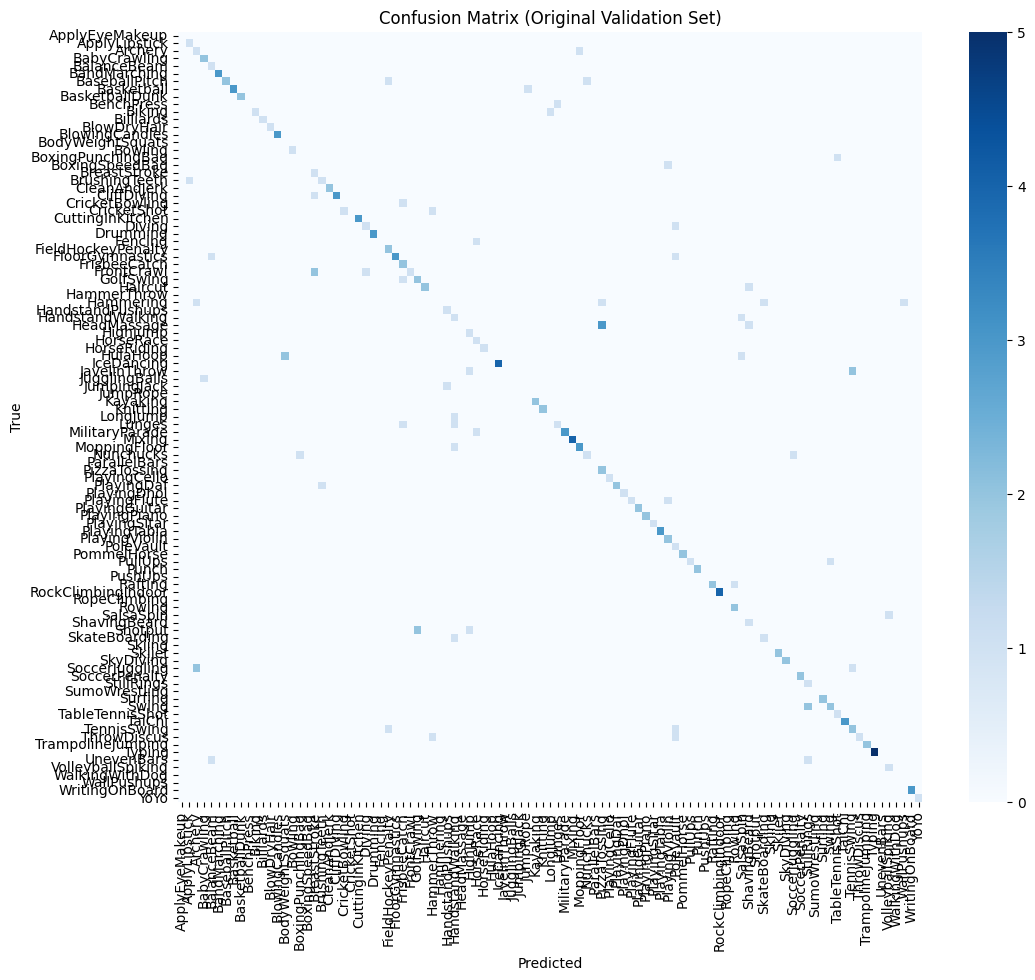

In [62]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Accuracy on original validation set: {acc:.4f}")

# Classification report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, labels=CFG.classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=CFG.classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=CFG.classes, yticklabels=CFG.classes, annot=False, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Original Validation Set)")
plt.show()

### For the compressed one

In [42]:
video_ids = [f"video_{i:03d}.mp4" for i in range(len(val_targets))]
gt_labels = {vid: CFG.classes[label] for vid, label in zip(video_ids, val_targets)}


✅ Accuracy on reconstructed videos: 0.4406

📊 Classification Report:
                    precision    recall  f1-score   support

    ApplyEyeMakeup       0.00      0.00      0.00         0
     ApplyLipstick       1.00      1.00      1.00         1
           Archery       0.00      0.00      0.00         2
      BabyCrawling       1.00      0.50      0.67         2
       BalanceBeam       0.20      1.00      0.33         1
      BandMarching       0.00      0.00      0.00         3
     BaseballPitch       0.50      0.50      0.50         4
        Basketball       0.00      0.00      0.00         4
    BasketballDunk       0.29      1.00      0.44         2
        BenchPress       0.08      1.00      0.15         1
            Biking       0.00      0.00      0.00         2
         Billiards       1.00      1.00      1.00         1
       BlowDryHair       0.00      0.00      0.00         1
    BlowingCandles       1.00      0.33      0.50         3
  BodyWeightSquats       0.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

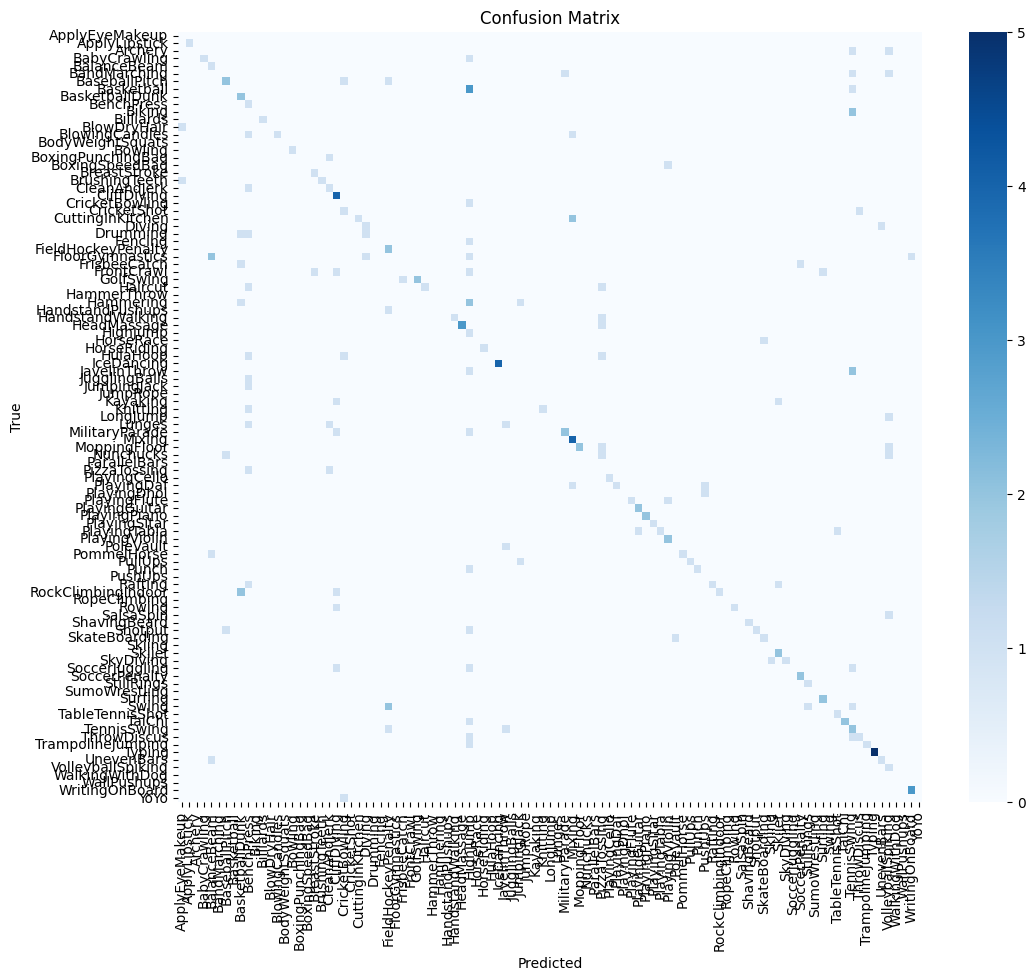

In [43]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_true = []
y_pred = []

for video_name, predicted_class in results:
    if video_name in gt_labels:
        y_pred.append(predicted_class)
        y_true.append(gt_labels[video_name])
    else:
        print(f"⚠️ {video_name} not found in ground truth.")

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Accuracy on reconstructed videos: {acc:.4f}")

# Classification report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, labels=CFG.classes))

# Confusion matrix (optional)
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=CFG.classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=CFG.classes, yticklabels=CFG.classes, annot=False, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Original

In [13]:
val_root = "/content/val_frames"
clip_folders = sorted(glob.glob(os.path.join(val_root, "video_*")))

In [14]:
for img_folder in clip_folders:
    output_folder = os.path.join("/content/compressed_val", os.path.basename(img_folder))
    os.makedirs(output_folder, exist_ok=True)


In [ ]:
# mot17_root = "BoostTrack/data/MOT17/test"
# sequence = "MOT17-01-DPM"
# img_folder = os.path.join(mot17_root, sequence, 'img1')
# output_folder = os.path.join('BoostTrack/data/MOT17-compressed', sequence)
# os.makedirs(output_folder, exist_ok=True)

In [15]:
def pad_to_multiple(x, m):
    """
    Reflect-pad so (H, W) is a multiple of m.
    SSF / other video codecs need m = 128; most image codecs work with 64.
    """
    B, C, H, W = x.shape
    Hp, Wp = (m - H % m) % m, (m - W % m) % m
    return F.pad(x, (0, Wp, 0, Hp), mode="reflect"), (H, W)

def bits_in(strings):
    return sum(len(s) * 8 for s in flatten(strings))

def flatten(l):
    for el in l:
        if isinstance(el, (list, tuple)):
            yield from flatten(el)
        else:
            yield el

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
quality = 6
model = ssf2020(quality=quality, metric='mse', pretrained=True).to(device)
model.eval()

Downloading: "https://compressai.s3.amazonaws.com/models/v1/ssf2020-mse-6-59dfb6f9.pth.tar" to /root/.cache/torch/hub/checkpoints/ssf2020-mse-6-59dfb6f9.pth.tar
100%|██████████| 133M/133M [00:08<00:00, 16.5MB/s]


ScaleSpaceFlow(
  (img_encoder): Encoder(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  )
  (img_decoder): Decoder(
    (0): ConvTranspose2d(192, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  )
  (img_hyperprio

In [17]:
video_codec = True
PAD_M = 128
to_tensor = transforms.ToTensor()
frames = sorted(glob.glob(os.path.join(img_folder, "*.jpg"))
                + glob.glob(os.path.join(img_folder, "*.png")))

In [ ]:
total_bits, orig_hws = 0, []
strings_list, shapes_list = [], []

clip = []
for fp in tqdm(frame_paths, desc="Loading frames"):
    img = Image.open(fp).convert("RGB")
    x   = to_tensor(img).unsqueeze(0).to(device)
    x, hw = pad_to_multiple(x, PAD_M)
    clip.append(x)
    orig_hws.append(hw)

with torch.no_grad():
    strings_list, shapes_list = model.compress(clip)

for i, (s, sh, hw) in enumerate(zip(strings_list, shapes_list, orig_hws)):
    torch.save({"strings": s, "shape": sh, "orig_hw": hw},
                os.path.join(output_folder, f"{i:06d}.pth"))
    total_bits += bits_in(s)

Loading frames: 100%|██████████| 450/450 [00:23<00:00, 19.22it/s]


In [ ]:
print(f"Compressed → {output_folder}")
print(f"Total size : {total_bits/8/1024:.1f} kB")

Compressed → BoostTrack/data/MOT17-compressed/MOT17-01-DPM
Total size : 125.1 kB


In [ ]:
psnr_sum = 0.0
n_pixels = 0

with torch.no_grad():
    if video_codec:
        recon_clip = model.decompress(strings_list, shapes_list)

    for i, fp in enumerate(tqdm(frame_paths, desc="Scoring")):
        if video_codec:
            x_hat = recon_clip[i]
        else:
            x_hat = model.decompress([strings_list[i]], [shapes_list[i]])[0]

        H, W  = orig_hws[i]
        x_hat = x_hat[..., :H, :W].clamp_(0, 1)

        x_ref = to_tensor(Image.open(fp).convert("RGB")).to(device)
        mse   = F.mse_loss(x_hat, x_ref)
        psnr  = -10 * torch.log10(mse)

        psnr_sum += psnr.item()
        n_pixels += H * W

avg_psnr = psnr_sum / len(frame_paths)
bpp      = total_bits / n_pixels

print(f"\nSequence average →  {bpp:.4f} bpp   |   {avg_psnr:.2f} dB PSNR")

Scoring:   0%|          | 0/450 [00:00<?, ?it/s]/tmp/ipykernel_292764/3201988151.py:18: UserWarning: Using a target size (torch.Size([3, 1080, 1920])) that is different to the input size (torch.Size([1, 3, 1080, 1920])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse   = F.mse_loss(x_hat, x_ref)
Scoring: 100%|██████████| 450/450 [00:24<00:00, 18.15it/s]


Sequence average →  0.0011 bpp   |   40.12 dB PSNR
